**Course website**: https://github.com/leomiquelutti/UFU-geofisica-1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade Federal de Uberlândia](http://www.ufu.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Agradecimentos especiais ao [Leonardo Uieda](www.leouieda.com) e ao [Grupo Geosci](http://geosci.xyz/)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Inversão de dados de uma bacia sedimentar 2D poligonal

## Objetivos

* Entender melhor como funciona a inversão de dados

A célula abaixo _prepara_ o ambiente

In [1]:
from fatiando.inversion import Smoothness1D
from fatiando.gravmag.basin2d import PolygonalBasinGravity
from fatiando.gravmag import talwani
from fatiando.mesher import Polygon
from fatiando.vis import mpl
from fatiando import utils
import numpy as np

C:\Users\leomi\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


A célula abaixo cria dados sintéticos para testar a inversão de dados. O resultado será um polígono.

In [2]:
# Make some synthetic data to test the inversion
# The model will be a polygon.
# Reverse x because vertices must be clockwise.
xs = np.linspace(0, 100000, 100)[::-1]
depths = (-1e-15*(xs - 50000)**4 + 8000 -
          3000*np.exp(-(xs - 70000)**2/(10000**2)))
depths -= depths.min()  # Reduce depths to zero
props = {'density': -300}
model = Polygon(np.transpose([xs, depths]), props)
x = np.linspace(0, 100000, 100)
z = -100*np.ones_like(x)
data = utils.contaminate(talwani.gz(x, z, [model]), 0.5, seed=0)

A célula abaixo executa a inversão, dada as condições iniciais descritas em `initial`

In [3]:
# Make the solver using smoothness regularization and run the inversion
misfit = PolygonalBasinGravity(x, z, data, 50, props, top=0)
regul = Smoothness1D(misfit.nparams)
solver = misfit + 1e-4*regul
# This is a non-linear problem so we need to pick an initial estimate
initial = 3000*np.ones(misfit.nparams)
solver.config('levmarq', initial=initial).fit()

C:\Users\leomi\Anaconda2\lib\site-packages\fatiando\inversion\optimization.py:302: RuntimeWarning: Exited because maximum iterations reached. Might not have achieved convergence. Try inscreasing the maximum number of iterations allowed.
  RuntimeWarning)


A célula abaixo cria a imagem da bacia e mostra o ajuste dos dados

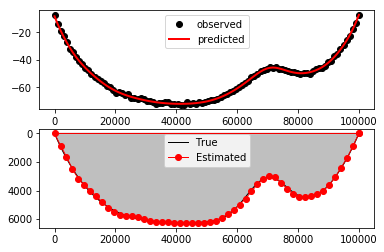

In [4]:
%matplotlib inline
mpl.figure()
mpl.subplot(2, 1, 1)
mpl.plot(x, data, 'ok', label='observed')
mpl.plot(x, solver[0].predicted(), '-r', linewidth=2, label='predicted')
mpl.legend()
ax = mpl.subplot(2, 1, 2)
mpl.polygon(model, fill='gray', alpha=0.5, label='True')
# The estimate_ property of our solver gives us the estimate basin as a polygon
# So we can directly pass it to plotting and forward modeling functions
mpl.polygon(solver.estimate_, style='o-r', label='Estimated')
ax.invert_yaxis()
mpl.legend()
mpl.show()